# La présence de bibliothèques autour des lycées augmente-t-elle la performance des lycées ?

In [1]:
# Setup

# Si la commande n'avait pas déjà été lancée danas le terminal
!pip install -r "requirements.txt"

import numpy as np
import pandas as pd
import geopandas as gpd
from src.download_file import download_file
from src.data_lycees import get_data_lycees
from src.data_lycees import merge_data_lycees
from src.data_biblio import get_data_biblio
from src.calcul_biblio_rayons import calcul_biblio_rayons
from src.calcul_distance import calcul_distance
from src.classe_modelisation import PipelineRegression
import matplotlib.pyplot as plt
from plotnine import *
import folium

pd.set_option('display.width', 140)

### Contexte

La performance des lycées est ici entendue comme le taux de réussite à l’examen du 
baccalauréat général, même si l’étude du taux de mention obtenu par les lycées est 
une piste envisagée. Celle-ci peut être expliquée par trois facteurs :

-	par le public de l’établissement (les élèves et leur origine sociale)
-	par le contexte de l’établissement (ses propriétés intrinsèques et possiblement les politiques 
    éducatives dont il fait objet)
-	par l’environnement de l’établissement (ce qui est relatif à sa situation géographique)

La question que l’on se pose se concentre sur les facteurs environnementaux de réussite scolaire, 
en proposant l’analyse de l’impact de la présence de bibliothèques autour des lycées. Les 
bibliothèques, qu’elles soient municipales, universitaires ou d’une autre nature, sont en effet 
des lieux qui peuvent favoriser la réussite des élèves par au moins deux moyens : d’abord, ce 
sont des lieux d’accès à la culture et à la connaissance ; d’autre part, ce sont aussi des 
lieux de révision privilégiés, notamment pour la préparation du baccalauréat .

La démarche adoptée consiste donc principalement à étudier le lien entre proximité d’une (ou de) 
bibliothèque(s) et performance des lycées. Cette proximité sera évaluée par la distance 
géographique, ou aussi par le nombre d’équipements disponibles dans un rayon donné. 


### Méthodes

@bourdieuHeritiersEtudiantsCulture1964

Après quelques statistiques descriptives et cartes pour illustrer le problème, des régressions 
linéaires seront mobilisées pour tester notre hypothèse, en contrôlant par d’autres variables. En 
partant des facteurs mis en évidence précédemment, la composition sociale du lycée sera appréciée 
à partir de l’indice de position sociale proposée par la Depp (cf. rubrique « Données »). Le 
contexte de l’établissement sera surtout pris en compte par le secteur de l’établissement 
(privé / public) et les filières et formations disponibles en son sein (filières technologiques 
et professionnelles, formations post-baccalauréat comme les BTS ou CPGE).


### Données

Pour ce qui est des données mobilisées, l’échelle d’observation sera le lycée. Le champ d’étude 
est limité aux lycées avec au moins 50 candidats (seuil à préciser) présents aux épreuves du 
baccalauréat général en 2024. Il s’agira alors de construire nos observations à partir de 
trois bases de données ouvertes produites par la Depp (service statistique ministériel de 
l’Education nationale) :
-	taux de réussite et de mention au bac (https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-gt_v2/information/)
-	indice de position sociale (https://data.education.gouv.fr/explore/dataset/fr-en-ips-lycees-ap2023/information/)
-	géolocalisation des lycées (https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/information/)

Enfin, le choix de se limiter à 2024 est lié à la disponibilité des données concernant les 
bibliothèques. En effet, nous utilisons la base permanente des équipements, qui n’est disponible 
en open data que pour 2024 (https://www.data.gouv.fr/datasets/base-permanente-des-equipements-1/).


## Analyse descriptive des données

### Les données sur les lycées

In [2]:
# Importation des données sur les lycées

lycees_resultats, lycees_ips, annuaire_education = get_data_lycees()
lycees_data = merge_data_lycees(lycees_resultats, lycees_ips, annuaire_education)
lycees_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1911 entries, 0 to 2212
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   uai                                 1911 non-null   object  
 1   annee                               1911 non-null   int64   
 2   presents_gnle                       1911 non-null   float64 
 3   taux_reu_gnle                       1911 non-null   float64 
 4   va_reu_gnle                         1910 non-null   float64 
 5   taux_men_gnle                       1911 non-null   float64 
 6   va_men_gnle                         1910 non-null   float64 
 7   ips_voie_gt                         1911 non-null   float64 
 8   ecart_type_voie_gt                  1911 non-null   float64 
 9   libelle_etablissement               1911 non-null   object  
 10  code_commune                        1911 non-null   object  
 11  code_departement           

/opt/python/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density : Removed 2 rows containing non-finite values.


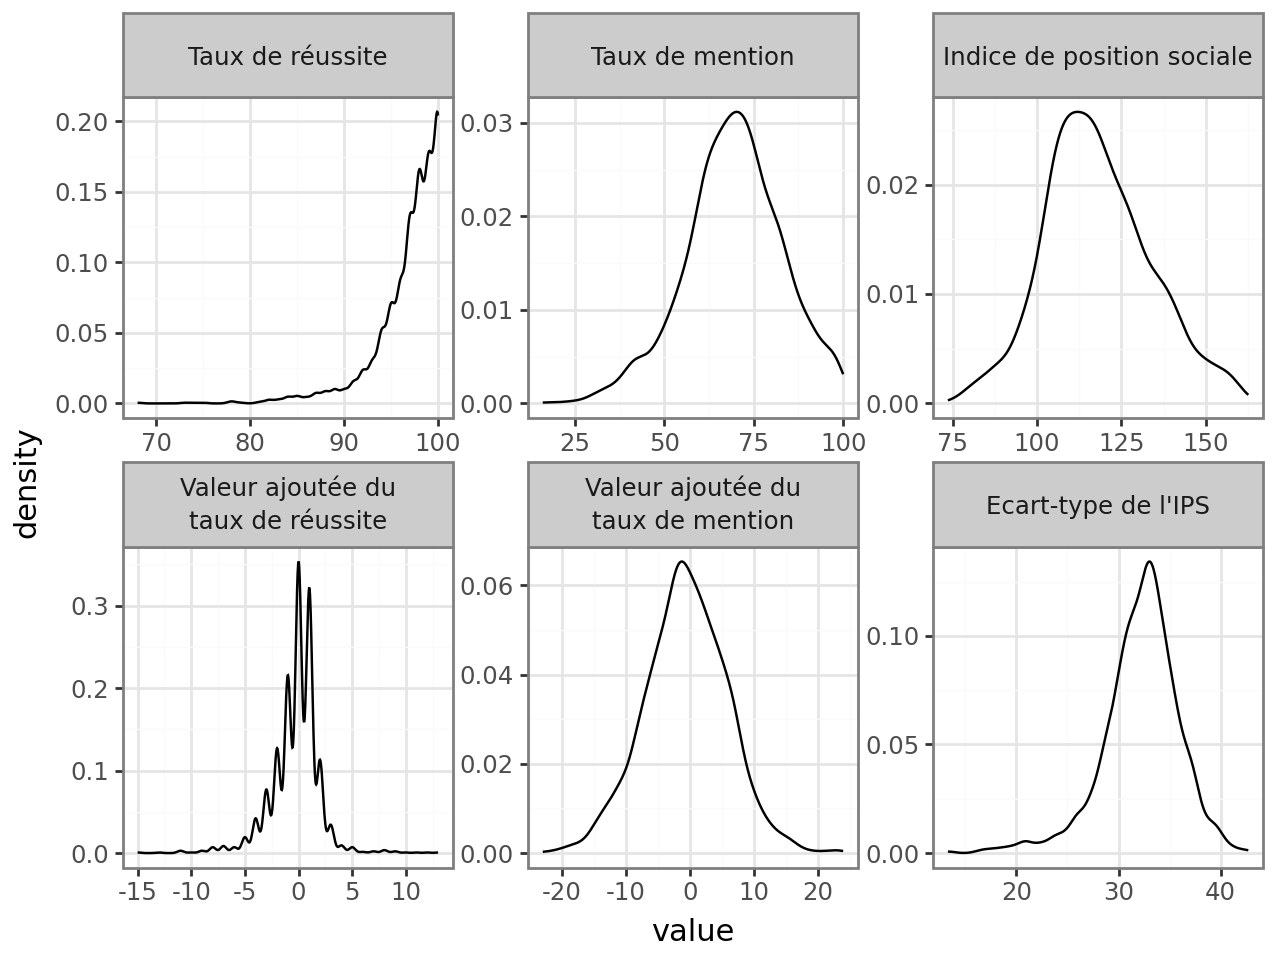

In [3]:
# Stats desc. - Lycées vars numériques

lycees_stat_desc_num = lycees_data.melt(
    id_vars = ['uai'],
    value_vars = [
        'taux_reu_gnle', 'va_reu_gnle', 'taux_men_gnle', 'va_men_gnle',
        'ips_voie_gt', 'ecart_type_voie_gt'
    ]
)#.sort_values('uai').reset_index()

lycees_stat_desc_num['variable'] = pd.Categorical(
    lycees_stat_desc_num['variable'],
    ordered=True,
    categories=[
        'taux_reu_gnle', 'taux_men_gnle', 'ips_voie_gt', 
        'va_reu_gnle', 'va_men_gnle', 'ecart_type_voie_gt'
    ]
).rename_categories([
    'Taux de réussite', 'Taux de mention', 
    'Indice de position sociale', 'Valeur ajoutée du\ntaux de réussite', 
    'Valeur ajoutée du\ntaux de mention', 'Ecart-type de l\'IPS'
])

(
    ggplot(lycees_stat_desc_num) +
    aes(x = 'value') +
    geom_density() +
    facet_wrap('variable', scales ='free') +
    theme_bw()
)

### Les données sur les bibliothèques

In [4]:
# Importation des données sur les bibliothèques

biblio = get_data_biblio()
biblio.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4958 entries, 0 to 5166
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   NOMETAB           4958 non-null   object  
 1   PAYS              4958 non-null   object  
 2   CODEPOSTAL        4958 non-null   object  
 3   LATITUDE          4958 non-null   float64 
 4   LONGITUDE         4958 non-null   float64 
 5   CONDITIONACCES_d  4373 non-null   object  
 6   TYPEETABABES_d    4938 non-null   object  
 7   TYPEFAMABES_d     4936 non-null   object  
 8   TYPEINST_d        4957 non-null   object  
 9   geometry          4958 non-null   geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 426.1+ KB


### Croiser les données des lycées et des bibliothèques

Après avoir considéré séparément les données des lycées et des bibliothèques, il faut maintenant les
faire se rencontrer. Une première façon de le faire est de proposer une interprétation graphique du 
problème soulevé par ce projet. Pour cela, illustrons-le à l'aide d'une carte où sont représentés à
la fois les lycées et les bibliothèques. Par simplicité, nous nous concentrerons ici sur le cas de 
la ville de Paris.

In [5]:
# Carte lycées & bibliothèques

lycees_75 = lycees_data[lycees_data['code_departement'] == "075"]
biblio_75 = biblio[biblio['CODEPOSTAL'].str[0:2] == "75"]

center = [biblio_75.LATITUDE.mean(), biblio_75.LONGITUDE.mean()]
m = folium.Map(
    location=center, 
    zoom_start=12
    )

tooltip = folium.GeoJsonTooltip(
    fields=['NOMETAB', 'TYPEETABABES_d', 'CONDITIONACCES_d'],
    aliases=['Nom :', 'TYPEETABABES : ', 'CONDITIONACCES_d :'],
    localize=True
)
folium.GeoJson(
    biblio_75,
    tooltip=tooltip, 
    marker=folium.Marker(icon=folium.Icon(color="green")),
).add_to(m)

tooltip = folium.GeoJsonTooltip(
    fields=['libelle_etablissement', 'statut_public_prive', 'presents_gnle', 'taux_reu_gnle', 'taux_men_gnle', 'ips_voie_gt'],
    aliases=[
        'Nom :', 'Secteur :', 'Nombre de candidats présents :', 'Taux de réussite :', 'Taux de mention',
        'Indice de position sociale :'
    ],
    localize=True
)
folium.GeoJson(
    lycees_75,
    tooltip=tooltip, 
    marker=folium.Marker(icon=folium.Icon(color="blue")),
).add_to(m)

m

interprétation de la carte

In [6]:
# Calculs - Distance à la bibliothèque la plus proche

lycees_data = calcul_distance(lycees_data, biblio)


La distance à la bibliothèque la plus proche

[np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6000000000000001), np.float64(0.7000000000000001), np.float64(0.8), np.float64(0.9), np.float64(1.0)]
[    0   179   281   381   495   653   845  1073  1474  3619 38873]


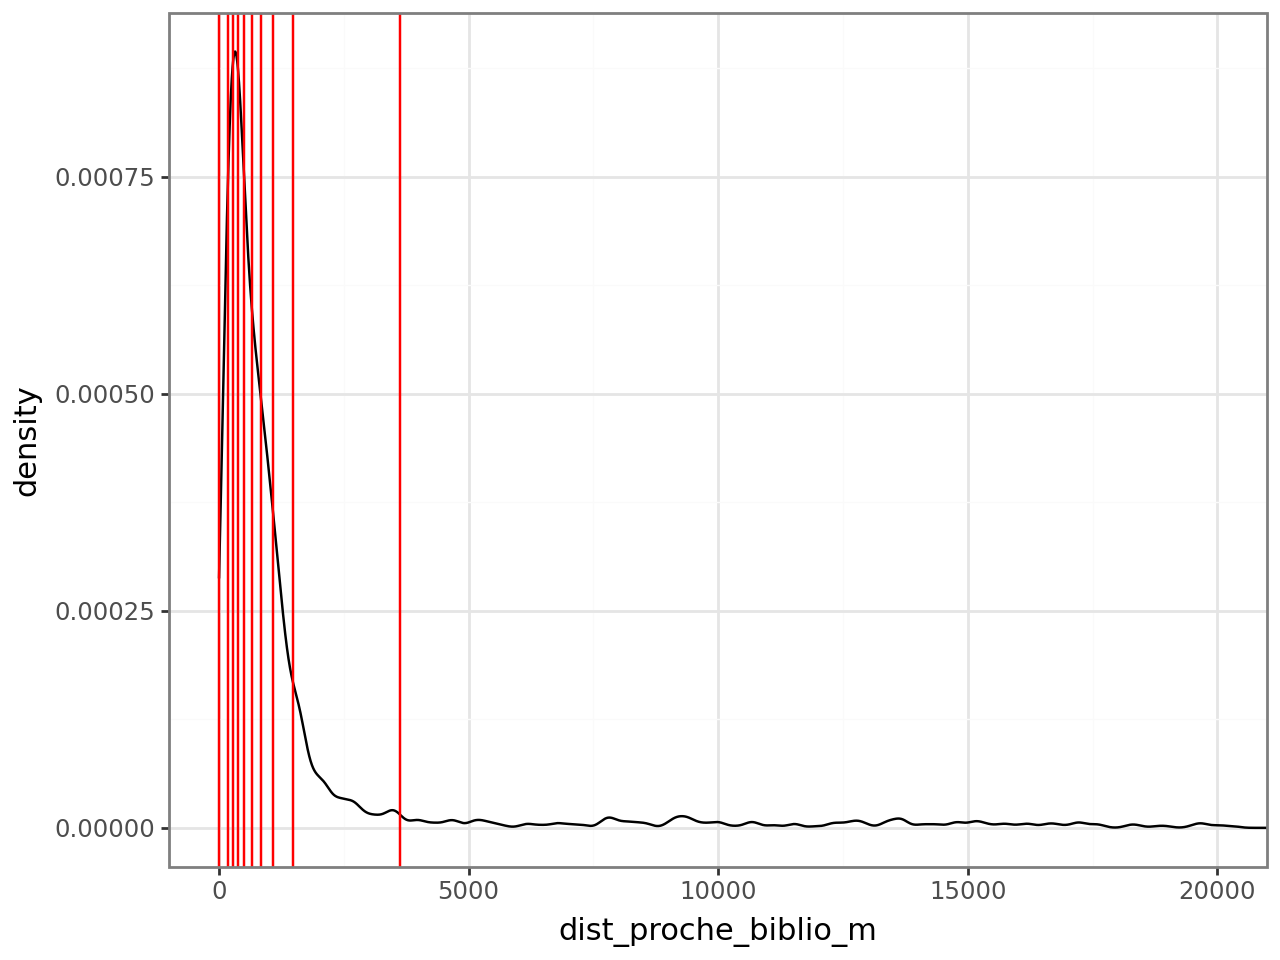

In [7]:
# Stats desc. - Distance à la bibliothèque la plus proche

probs = list(np.arange(0, 1.1, 0.1))
temp_quantile = np.quantile(lycees_data['dist_proche_biblio_m'], q = probs)
temp_quantile = np.quantile(lycees_data['dist_proche_biblio_m'], q = probs)
print(probs)
print(temp_quantile.round().astype(int))
(
    ggplot(lycees_data) +
    geom_density(aes(x = 'dist_proche_biblio_m'), n = 10000) + 
    coord_cartesian(xlim = [0, 20000]) +
    geom_vline(xintercept=temp_quantile.tolist(), color="red") +
    theme_bw()
)

Interprétation

In [8]:
# Calculs - Présence et nombre de bibliothèques à proximité

lycees_data = calcul_biblio_rayons(lycees_data, biblio)

lycees_data = lycees_data.assign(
    dummy_biblio_500 = lycees_data['nb_biblio_500'] > 0,
    dummy_biblio_1000 = lycees_data['nb_biblio_1000'] > 0,
    dummy_biblio_2000 = lycees_data['nb_biblio_2000'] > 0,
    dummy_biblio_5000 = lycees_data['nb_biblio_5000'] > 0,
)


La présence et le nombre de bibliothèques à proximité

In [9]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

(
    lycees_data
    .groupby(['dummy_biblio_500', 'dummy_biblio_1000', 'dummy_biblio_2000', 'dummy_biblio_5000'])
    .size()
    .div(lycees_data.shape[0])
    .mul(100)
)

dummy_biblio_500  dummy_biblio_1000  dummy_biblio_2000  dummy_biblio_5000
False             False              False              False                 9.035840
                                                        True                  5.451792
                                     True               True                 18.677436
                  True               True               True                 26.400808
True              True               True               True                 40.434124
dtype: float64

In [10]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

pd.crosstab(
    lycees_data['libelle_region'],
    lycees_data['dummy_biblio_5000']
    )

dummy_biblio_5000,False,True
libelle_region,,
Auvergne-Rhône-Alpes,38,230
Bourgogne-Franche-Comté,2,80
Bretagne,17,87
Centre-Val de Loire,1,60
Grand Est,10,160
Hauts-de-France,10,157
Ile-de-France,11,424
Normandie,7,87
Nouvelle-Aquitaine,24,141


Interprétation

# **Modélisation du Taux de Mention**

## *Introduction*

Cette partie vise à identifier et quantifier les déterminants du taux de mention au baccalauréat. L'objectif est de modéliser cette variable en fonction de caractéristiques internes aux lycées et de leur environnement externe, avec un intérêt particulier pour l'accès aux bibliothèques. Le taux de mention est privilégié au taux de réussite en raison de sa plus grande variance, suggérant une sensibilité accrue à des facteurs différenciants comme l'environnement culturel.

## *Cadre méthodologique*

L'analyse s'appuie sur la **régression linéaire multiple**, choisie pour sa capacité à fournir des modèles explicables, à quantifier l'ampleur des effets marginaux et à tester leur significativité statistique.

Les variables explicatives se répartissent en deux groupes :
*   **Caractéristiques internes** : Indice de Position Sociale (IPS), statut (public/privé) et taux de réussite.
*   **Caractéristiques externes** : Nombre de bibliothèques à différentes distances du lycée.

## *Démarche analytique*

La modélisation suit une progression structurée en cinq étapes pour garantir la robustesse des résultats :

1.  **Analyse exploratoire** : Visualisation des relations initiales entre variables.
2.  **Diagnostic de multicolinéarité** : Calcul des Facteurs d'Inflation de la Variance (VIF) pour identifier les redondances entre variables explicatives.
3.  **Stratégie adaptative** :
    *   Si la multicolinéarité est faible : régression avec toutes les variables pertinentes.
    *   Si la multicolinéarité est problématique : sélection stepwise des variables minimisant le Critère d'Information d'Akaike (AIC).

## *Plan*

Cinq modélisations successives seront conduites pour évaluer l'impact des bibliothèques à différentes échelles spatiales :

1.  **Rayon de 500 mètres** : Évalue l'impact de la proximité immédiate.
2.  **Rayon de 1 kilomètre** : Mesure l'influence à l'échelle du quartier.
3.  **Rayon de 2 kilomètres** : Analyse l'effet à l'échelle du secteur.
4.  **Rayon de 5 kilomètres** : Examine la corrélation avec l'environnement départemental.
5.  **Analyse par tranches de distance** : Compare l'effet spécifique de chaque couronne spatiale pour identifier l'échelle d'impact la plus déterminante.

## *Outil d'analyse*

Pour garantir la reproductibilité et la rigueur de cette démarche, une classe Python (`PipelineRegression`) a été développée. Cet outil intègre l'ensemble des méthodes nécessaires, depuis les diagnostics préliminaires jusqu'à l'estimation des modèles et la sélection stepwise, permettant d'exécuter l'analyse complète de manière systématique et cohérente.

## **Initialisation de l'environnement d'analyse**

La phase d'initialisation établit le cadre méthodologique stable pour la modélisation du taux de mention au baccalauréat général. Cette configuration vise à isoler et mesurer l'effet net des caractéristiques environnementales, en contrôlant de manière rigoureuse pour les facteurs internes aux établissements.


L'analyse repose sur trois composants définis de manière permanente :

1.  **Les données** : Le jeu de données issu des phases préliminaires de nettoyage et de préparation, constitue la base de l'étude. Une copie de ce jeu est utilisée pour préserver l'intégrité des données sources.

2.  **Les variables de contrôle internes** : Un socle de trois variables liées aux caractéristiques intrinsèques des lycées est systématiquement inclus :
    *   L'Indice de Position Sociale moyen , pour contrôler l'origine socio-économique du public scolaire.
    *   Le statut de l'établissement , pour tenir compte des différences structurelles et organisationnelles.
    *   Le taux de réussite au baccalauréat général , pour intégrer le niveau académique global de l'établissement comme facteur préalable à l'obtention de mentions.

3.  **La variable cible** : Le taux de mention est retenu comme indicateur de performance, privilégié pour sa plus grande variance et sa sensibilité supposée aux facteurs d'environnement.


Cette initialisation fixe le modèle de référence, expliquant la variable cible par les seuls déterminants internes. La démarche consiste ensuite à **enrichir itérativement ce modèle de base** en y introduisant différents ensembles de **variables explicatives externes**.

Ces variables externes, principalement liées à la présence et à la densité des bibliothèques à proximité des lycées (par exemple, le nombre de bibliothèques dans un rayon de 500 mètres ou de 1 000 mètres), constituent le véritable objet de l'étude. Leur ajout successif au modèle de base permettra d'évaluer si elles apportent un pouvoir explicatif significatif, une fois l'influence des facteurs internes neutralisée. L'outil principal de cette analyse itérative est la classe `PipelineRegression`, qui encapsule l'ensemble des méthodes nécessaires à cette démarche.

In [11]:
model = PipelineRegression()
data = lycees_data.copy()
vars_internes = ["ips_voie_gt", "statut_public_prive","taux_reu_gnle"]
target = "taux_men_gnle"
print(PipelineRegression.__doc__)


Pipeline de modélisation de régression linéaire.

Cette classe implémente une approche structurée et reproductible pour la
modélisation statistique, inspirée des bonnes pratiques en science des données.

Attributs
---------
X : array-like
    Variables explicatives standardisées
y : array-like
    Variable cible
model : statsmodels.regression.linear_model.RegressionResultsWrapper
    Modèle statistique ajusté
scaler : StandardScaler
    Standardiseur pour les variables explicatives
standardisation : bool
    Indicateur de standardisation des données
stepwise_best : statsmodels.regression.linear_model.RegressionResultsWrapper
    Meilleur modèle de la sélection stepwise
    
Références (Travaux de Lino Galiana)
------------------------------------
- https://pythonds.linogaliana.fr
- https://doi.org/10.5281/zenodo.8229676



## **1. Rayon de 500 mètres : La proximité immédiate**  

Cette première modélisation a pour objectif d'évaluer l'effet de la présence de bibliothèques dans l'environnement immédiat des lycées. Un rayon de **500 mètres** représente une zone de **proximité piétonne directe**, accessible en quelques minutes à pied. Elle permet de tester l'hypothèse selon laquelle la disponibilité d'une ressource culturelle et de travail **à très courte distance**—potentiellement utilisable sur les temps de pause ou juste après les cours—peut influencer positivement les résultats des élèves, en facilitant un accès spontané et régulier.

In [12]:
features_1 = vars_internes+["nb_biblio_500"]

* ### **Les Visualisations graphiques**

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

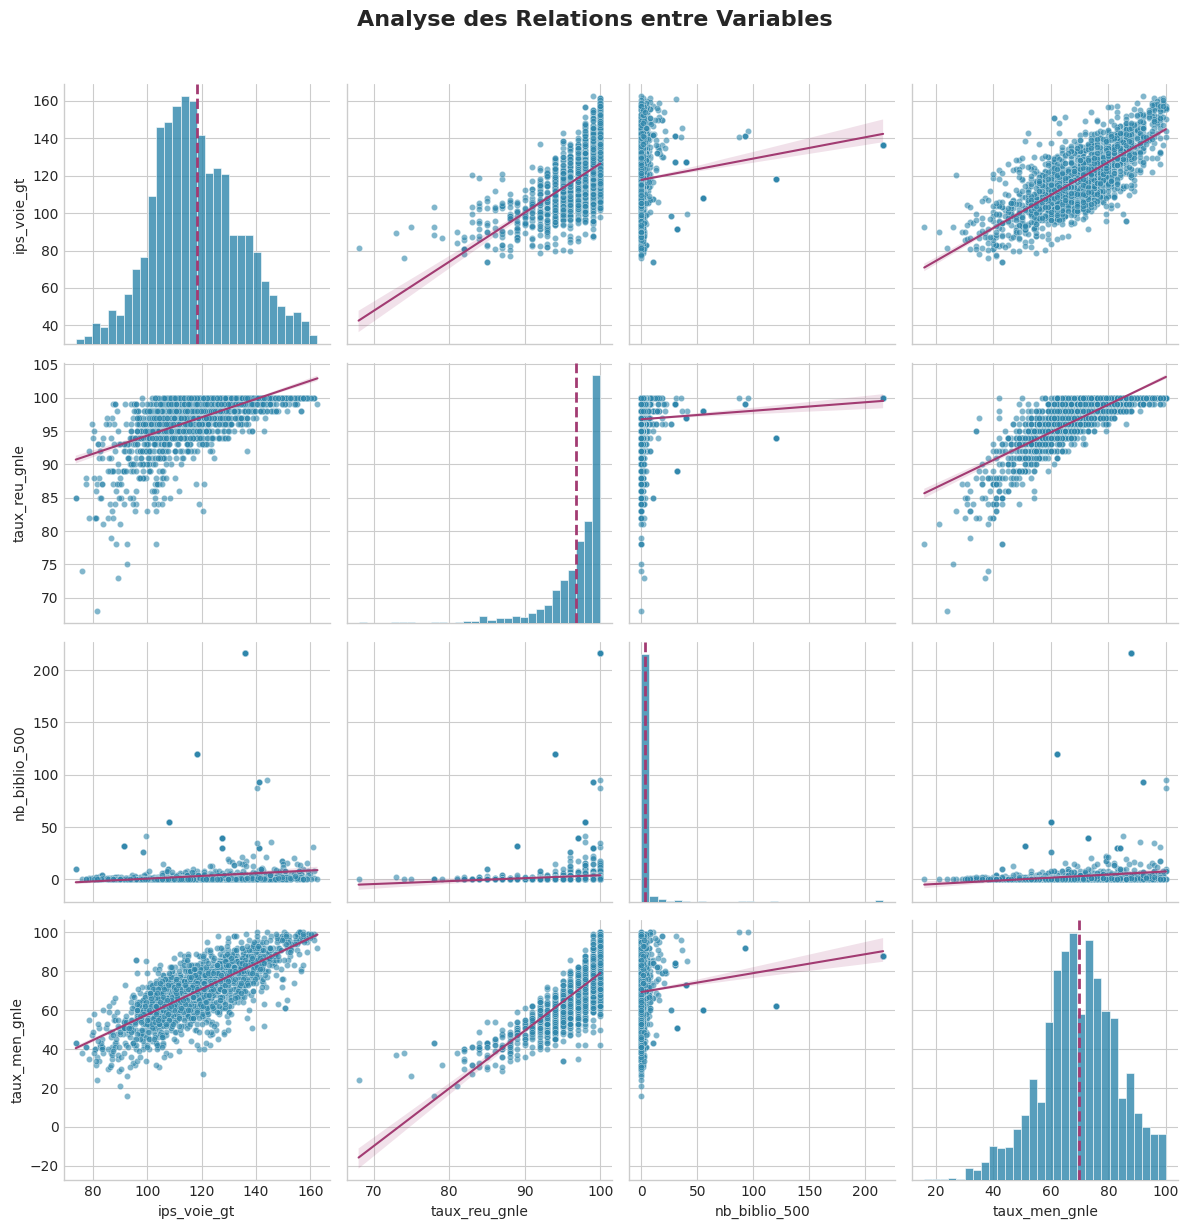

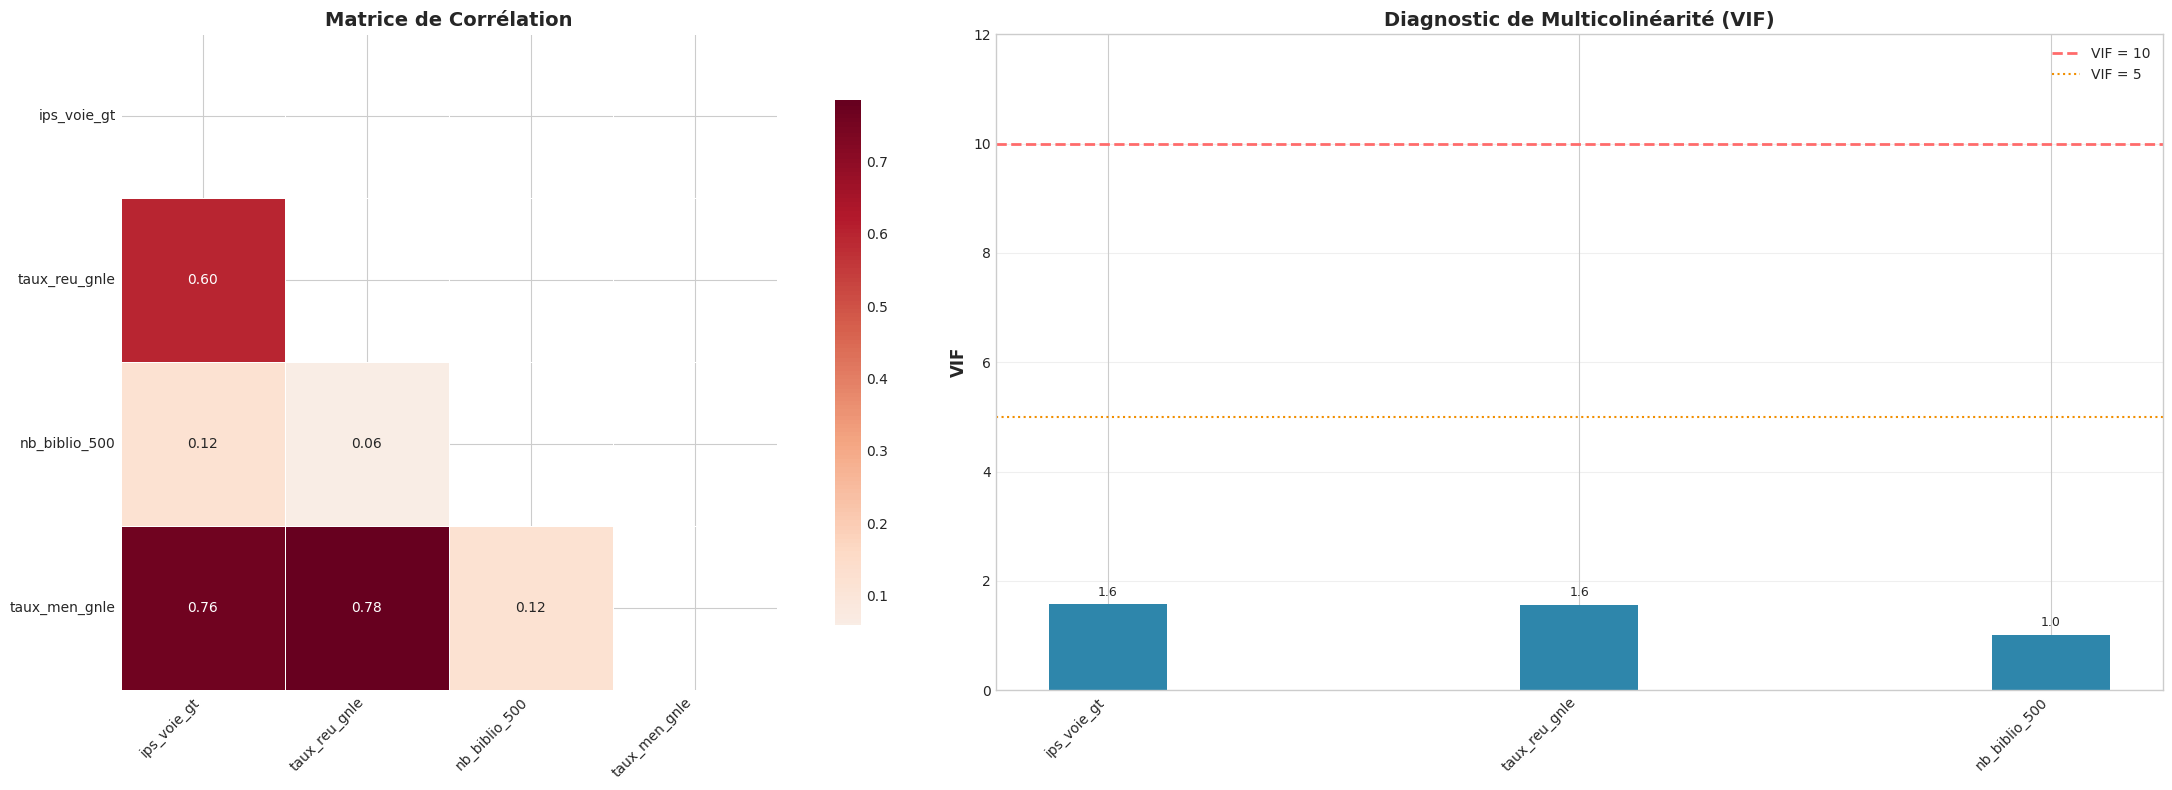

In [13]:
paires = model.paires_plot(data=data , features=features_1 , target=target)
headmap_vif = model.headmap_vif(data = data , features = features_1 , target = target)
plt.show()

* ### **Analyse et Interprétation des graphiques**

* ### **Résultats de la Régression**

In [14]:

model.fit(data=data , features=features_1 , target=target , include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1042.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:42:59   Log-Likelihood:                -6612.9
No. Observations:                1981   AIC:                         1.324e+04
Df Residuals:                    1976   BIC:                         1.326e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

* ### **Analyse et Interprétation des résultats de la régression**

## **2. Rayon de 1 kilomètre : L'échelle du quartier**

La deuxième modélisation élargit le périmètre d'étude à **1 kilomètre**. Ce rayon correspond à une **échelle de quartier**, représentant une distance qui reste accessible à pied (environ 10-15 minutes) ou en transport très court. Elle vise à mesurer si un environnement légèrement plus large, offrant potentiellement un choix ou une **diversité d'établissements** (bibliothèques municipales, médiathèques), a un impact distinct et complémentaire par rapport à la seule proximité immédiate.

In [15]:

features_2 = vars_internes+["nb_biblio_1000"]

* ### **Les Visualisations graphiques**

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

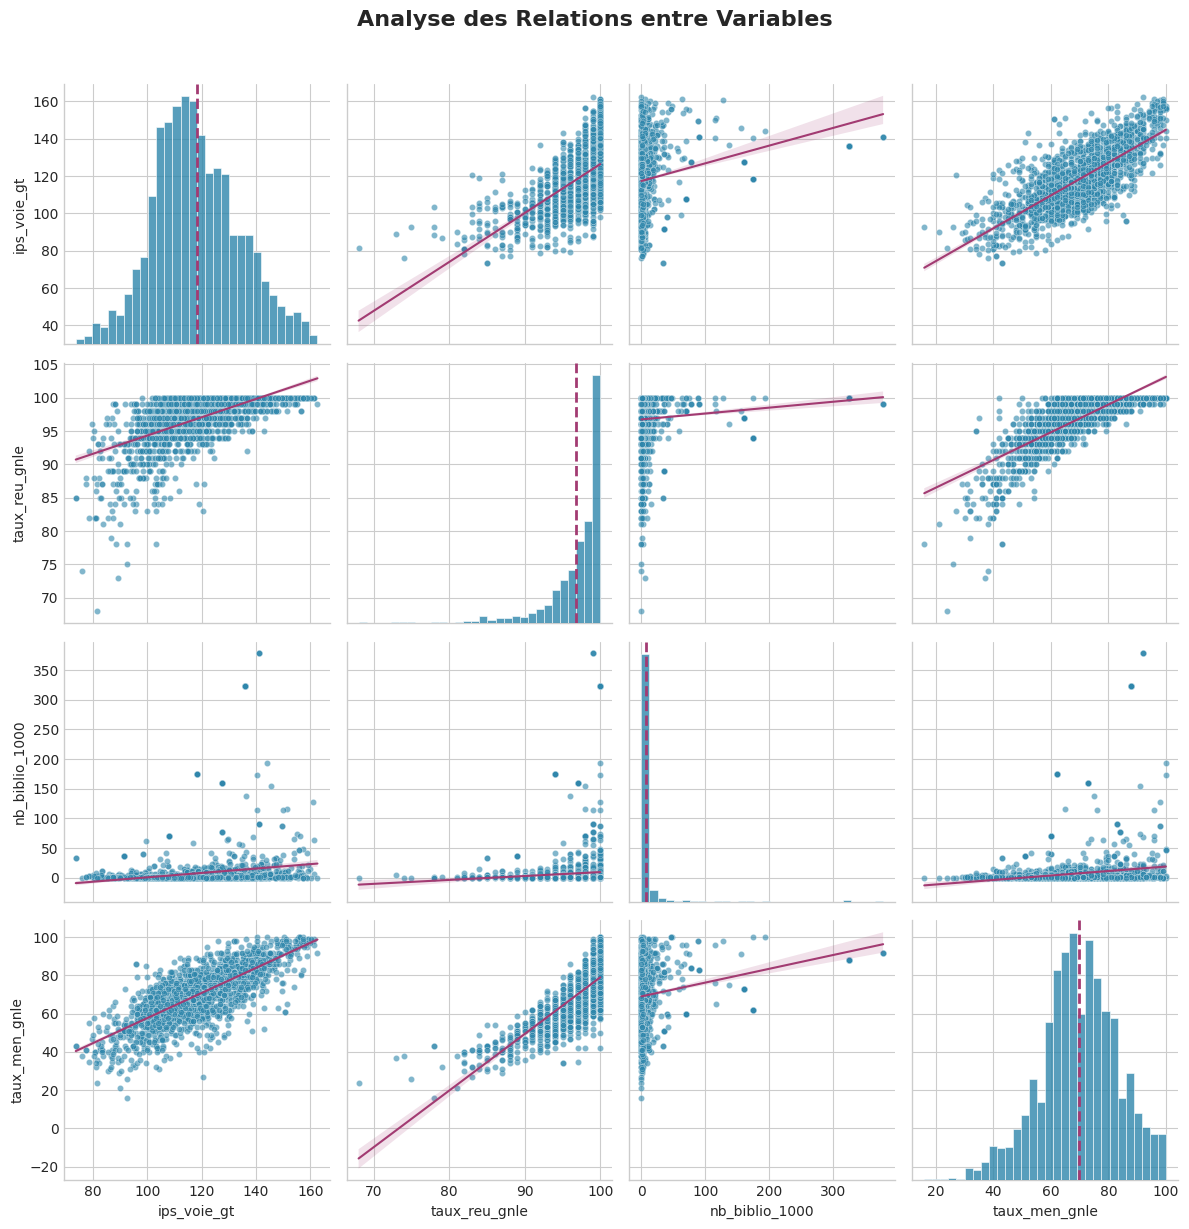

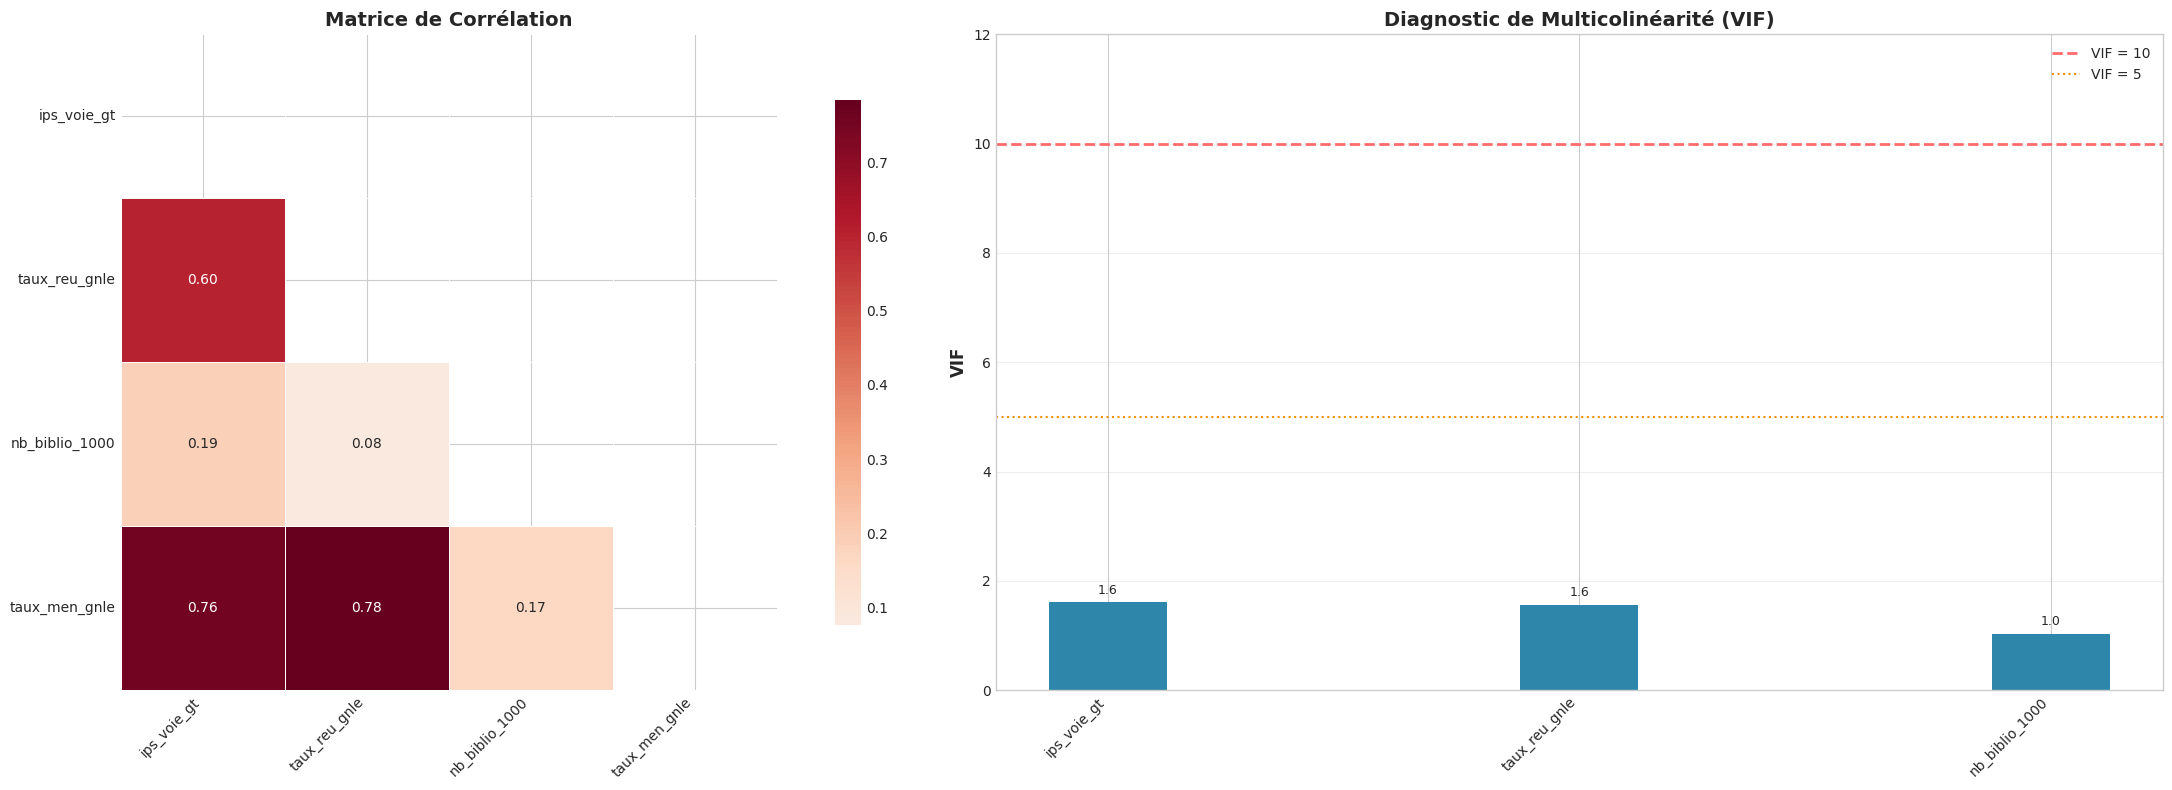

In [16]:
paires = model.paires_plot(data=data , features=features_2 , target=target)
headmap_vif = model.headmap_vif(data = data , features = features_2 , target = target)
plt.show()

* ### **Analyse et Interprétation des graphiques**

* ### **Résultats de la Régression**

In [17]:

model.fit(data=data , features=features_2 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1042.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:43:04   Log-Likelihood:                -6609.8
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.326e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

* ### **Analyse et Interprétation des résultats de la régression**

## **3. Rayon de 2 kilomètres : L'échelle secteur**  

Cette troisième étape examine l'influence des bibliothèques dans un rayon de **2 kilomètres**. À cette échelle, on s'intéresse à l'effet d'un **bassin de ressources élargi**, souvent couvert par un trajet en vélo ou en quelques arrêts de bus. Elle permet d'évaluer si la **densité globale** de l'offre culturelle et éducative dans un secteur plus vaste (pouvant inclure des bibliothèques universitaires ou spécialisées) constitue un facteur explicatif de la performance scolaire, au-delà de la simple proximité de voisinage.

In [18]:
features_3 = vars_internes+["nb_biblio_2000"]

* ### **Les Visualisations graphiques**

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

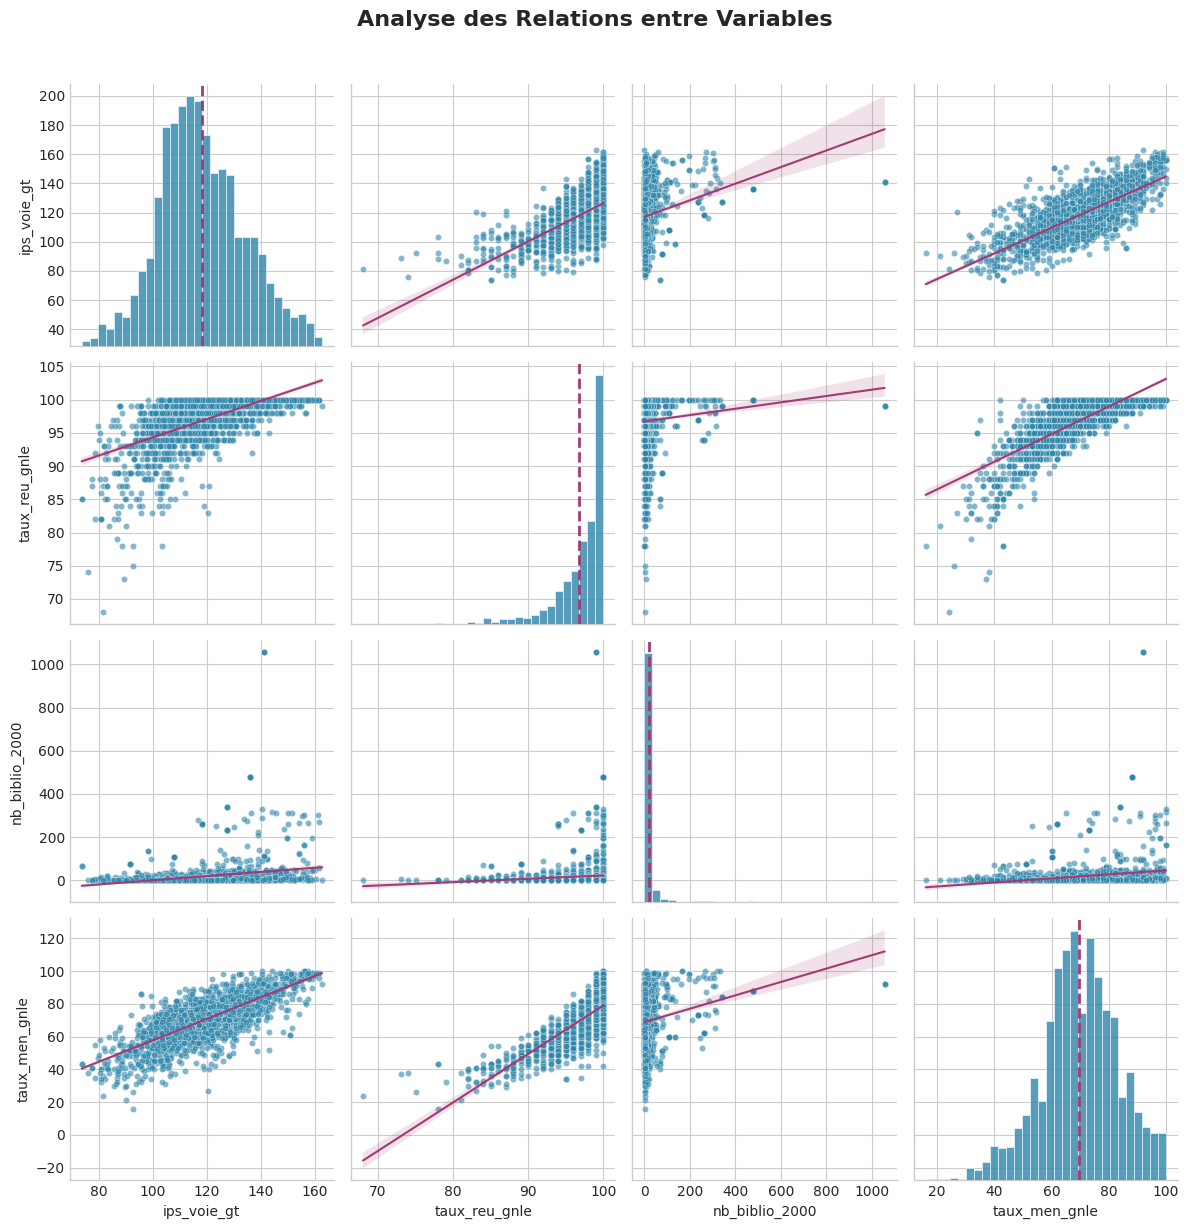

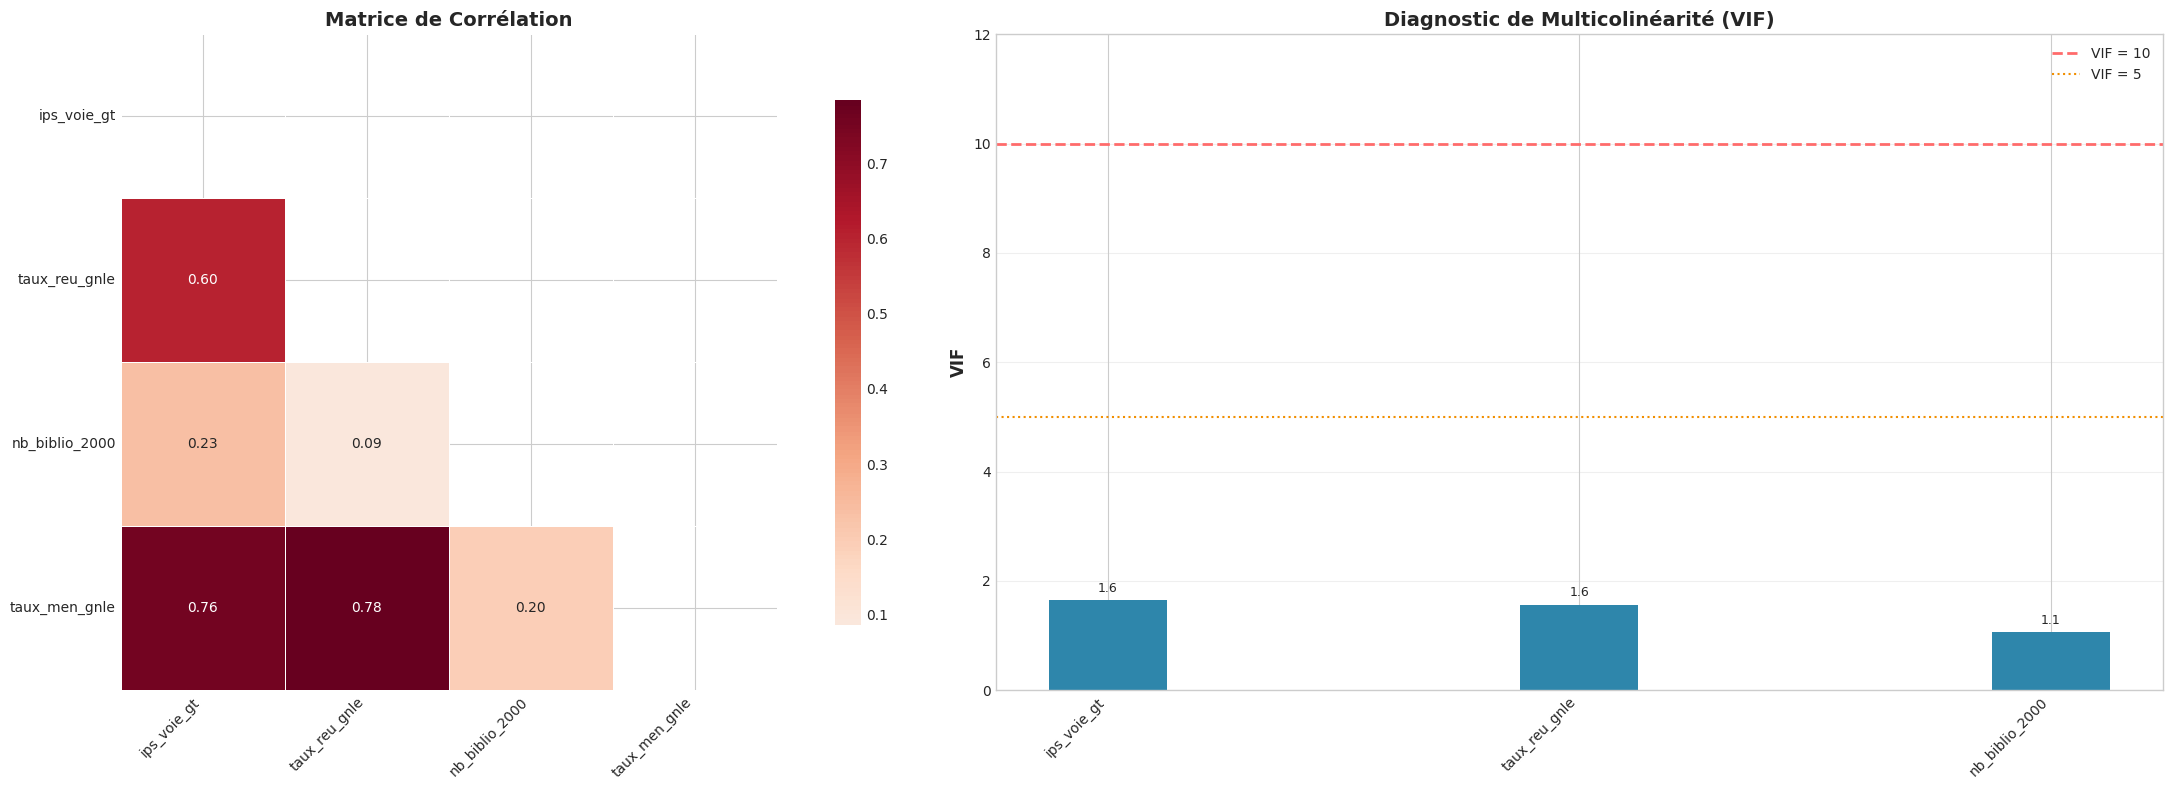

In [19]:
paires = model.paires_plot(data=data , features=features_3 , target=target)
headmap_vif  = model.headmap_vif(data = data , features = features_3 , target = target)
plt.show()

* ### **Analyse et Interprétation des graphiques**

* ### **Résultats de la Régression**

In [20]:

model.fit(data=data , features=features_3 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1034.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:43:09   Log-Likelihood:                -6607.6
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.325e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

* ### **Analyse et Interprétation des résultats de la régression**

## **4. Rayon de 5 kilomètres : L'environnement départemental** 

Enfin, la quatrième modélisation adopte un rayon très large de **5 kilomètres**. Cette échelle capture l'**offre culturelle accessible sur l'ensemble d'un bassin de vie ou d'une petite agglomération**. Elle teste l'hypothèse d'un **effet de contexte territorial** : la performance d'un lycée est-elle corrélée à la richesse de l'environnement éducatif et culturel dans lequel il s'insère, même si les équipements ne sont pas situés à proximité immédiate ? Cela permet de distinguer l'effet d'une ressource spécifique de celui d'un environnement global favorable.

In [21]:
features_4 = vars_internes+["nb_biblio_5000"]

* ### **Les Visualisations graphiques**

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

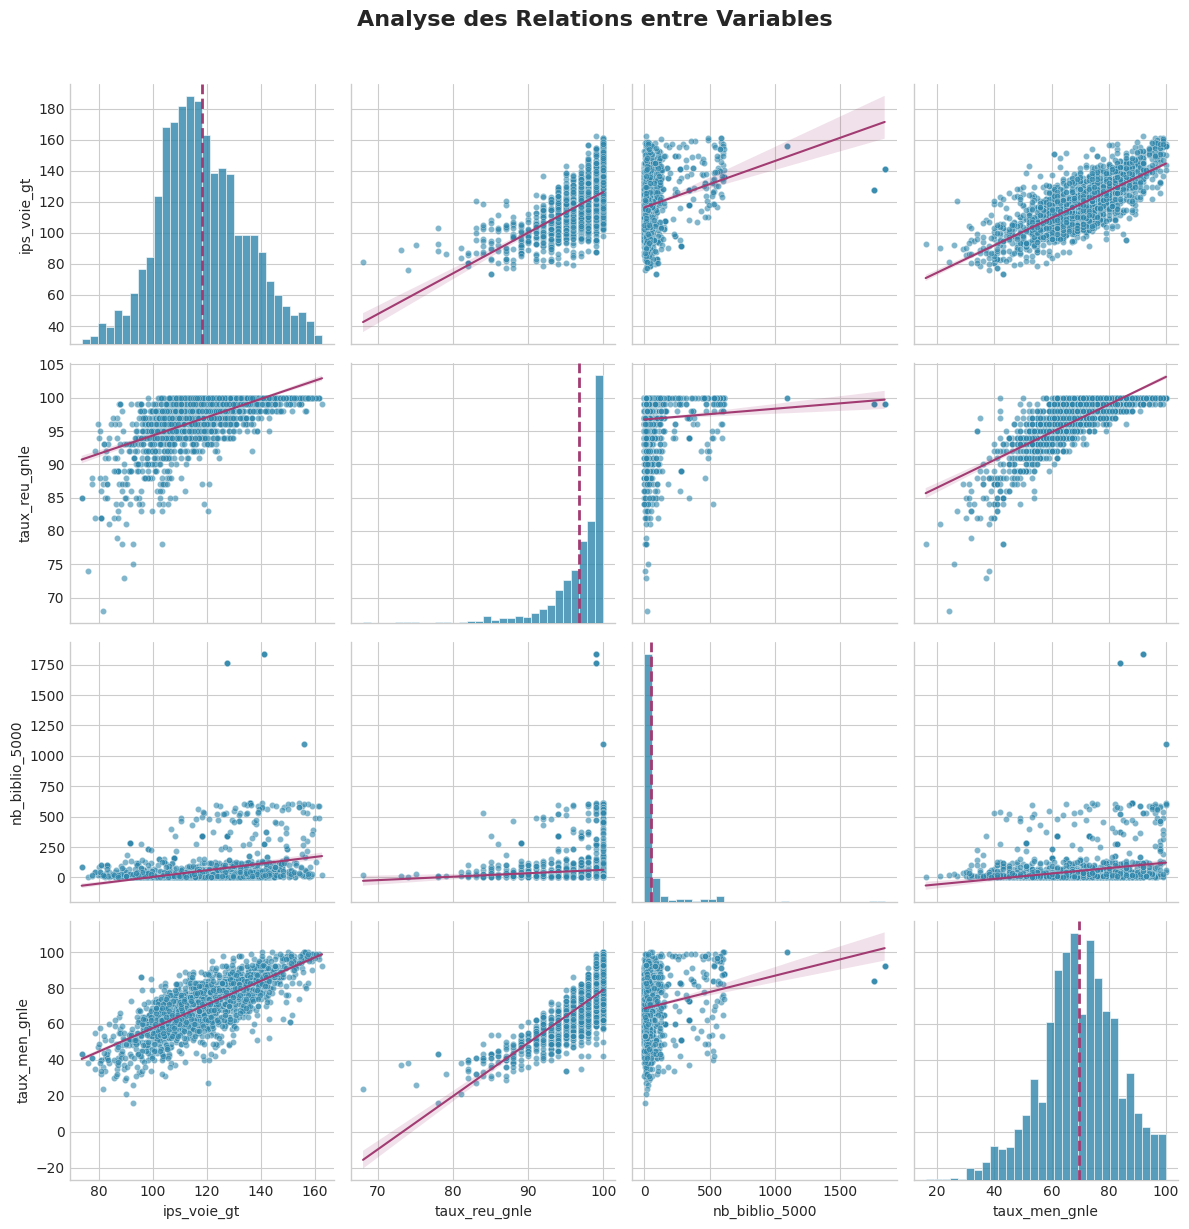

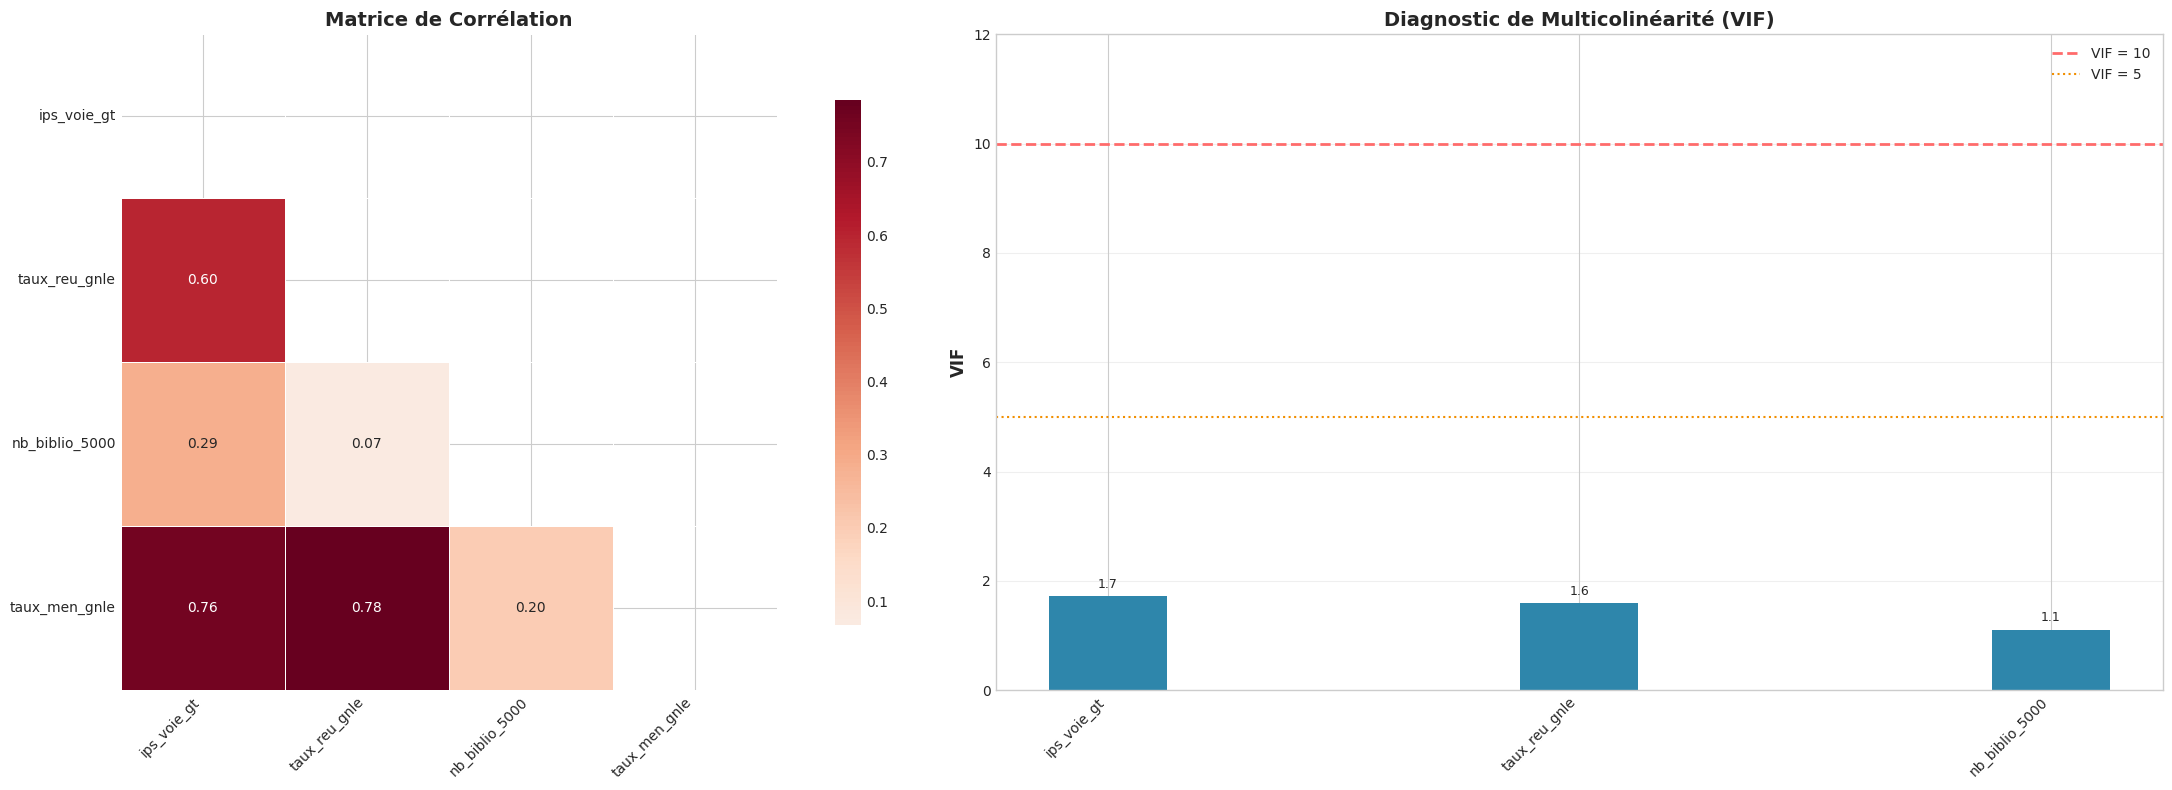

In [22]:
paires = model.paires_plot(data=data , features=features_4 , target=target)
headmap_vif = model.headmap_vif(data = data , features = features_4 , target = target)
plt.show()

* ### **Analyse et Interprétation des graphiques**

* ### **Résultats de la Régression**

In [23]:

model.fit(data=data , features=features_4 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1028.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:43:13   Log-Likelihood:                -6609.5
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.326e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

* ### **Analyse et Interprétation des résultats de la régression**

## **5. Analyse par Tranches de Distance**  

Après avoir évalué séparément l'influence des bibliothèques à différentes échelles spatiales, cette dernière modélisation adopte une **approche intégrative et comparative**. L'objectif n'est plus de mesurer un effet global à un rayon donné, mais de **décomposer cet effet par tranches de distance concentriques** et d'identifier laquelle contribue le plus à expliquer la performance scolaire.


Contrairement aux modèles précédents qui utilisaient des variables de comptage cumulatif (`nb_biblio_500`, `nb_biblio_1000`), cette modélisation intègre simultanément quatre indicateurs distincts et non-cumulatifs :

1.  **`nb_biblio_0_500`** : Nombre de bibliothèques *uniquement* dans la première couronne (0-500 m).

2.  **`nb_biblio_500_1000`** : Nombre de bibliothèques *uniquement* entre 500 m et 1 km.

3.  **`nb_biblio_1000_2000`** : Nombre de bibliothèques *uniquement* entre 1 km et 2 km.

4.  **`nb_biblio_2000_5000`** : Nombre de bibliothèques *uniquement* entre 2 km et 5 km.

Cette spécification présente plusieurs avantages analytiques décisifs :

*   **Dissociation des Effets** : Elle permet d'isoler et de comparer l'**effet marginal propre** à chaque anneau de distance. On peut ainsi déterminer si l'accès à une bibliothèque à **500 mètres** a un rendement (en termes d'impact sur les mentions) supérieur ou inférieur à l'accès à une bibliothèque supplémentaire située **entre 1 et 2 kilomètres**.

*   **Identification du Pivot Spatial** : Le modèle révèle à partir de quelle distance l'effet des bibliothèques devient statistiquement non significatif ou négligeable. Cela permet de définir un **périmètre d'action prioritaire** pour les politiques publiques visant à améliorer l'environnement éducatif.

*   **Robustesse face à la Colinéarité** : En utilisant des tranches exclusives plutôt que des comptages cumulés, on réduit fortement la colinéarité mathématique entre les variables. Cela améliore la stabilité des estimations et la fiabilité de l'interprétation des coefficients.


Ce modèle "global" ne vise pas nécessairement à obtenir le meilleur pouvoir prédictif, mais à répondre à une question causale fine : **"À quelle distance une bibliothèque a-t-elle le plus d'impact ?"**.

L'analyse des coefficients standardisés et de leur significativité permettra de :
1.  **Hiérarchiser les échelles d'influence** et potentiellement identifier un **seuil de distance** au-delà duquel l'effet décroît fortement.

2.  **Affiner l'interprétation des résultats précédents**. Par exemple, un effet significatif dans le modèle "rayon de 2000 m" pourrait en réalité être porté principalement par les bibliothèques de la tranche 0-500m, masqué auparavant par l'agrégation des données.

3.  **Guider des recommandations ciblées** : Les résultats pourront indiquer s'il est plus efficace, pour améliorer les résultats, de densifier l'offre en très grande proximité des lycées ou de garantir un accès à une ressource de qualité dans un rayon plus large.

En somme, cette modélisation finale offre une lecture nuancée et spatialement discriminante de l'influence des bibliothèques, venant compléter et préciser les enseignements des approches par rayon unique.

In [24]:
data["nb_biblio_0_500"] = data["nb_biblio_500"]
data["nb_biblio_500_1000"] = data["nb_biblio_1000"] - data["nb_biblio_500"]
data["nb_biblio_1000_2000"] = data["nb_biblio_2000"] - data["nb_biblio_1000"]
data["nb_biblio_2000_5000"] = data["nb_biblio_5000"] - data["nb_biblio_2000"]

In [25]:

features_5 = vars_internes + ["nb_biblio_0_500", "nb_biblio_500_1000", "nb_biblio_1000_2000", "nb_biblio_2000_5000"]

* ### **Les Visualisations graphiques**

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

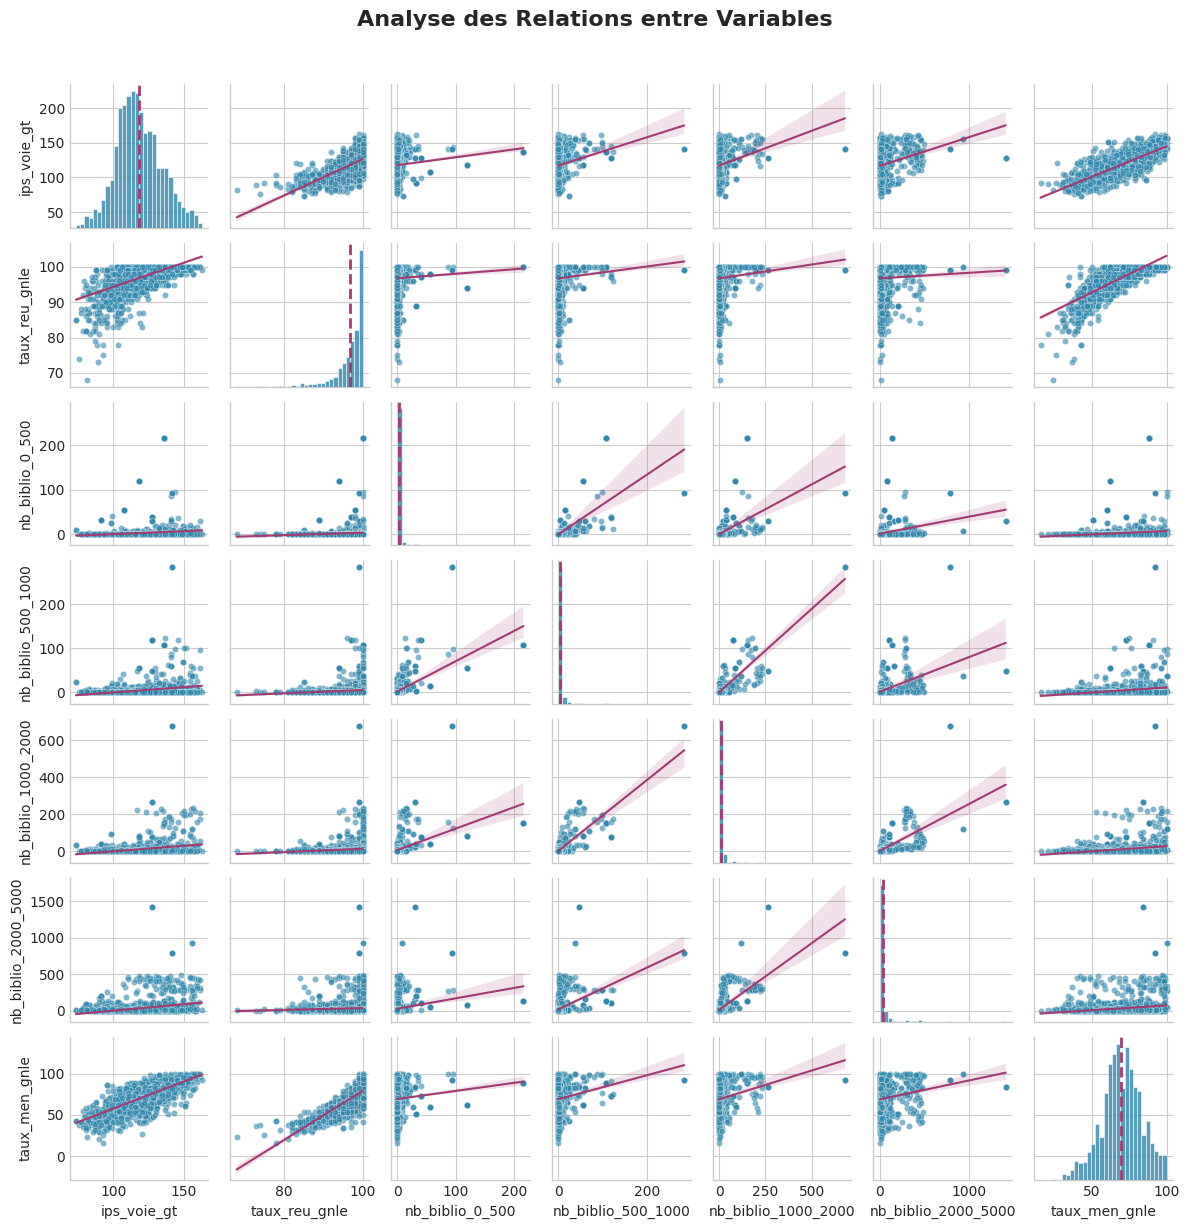

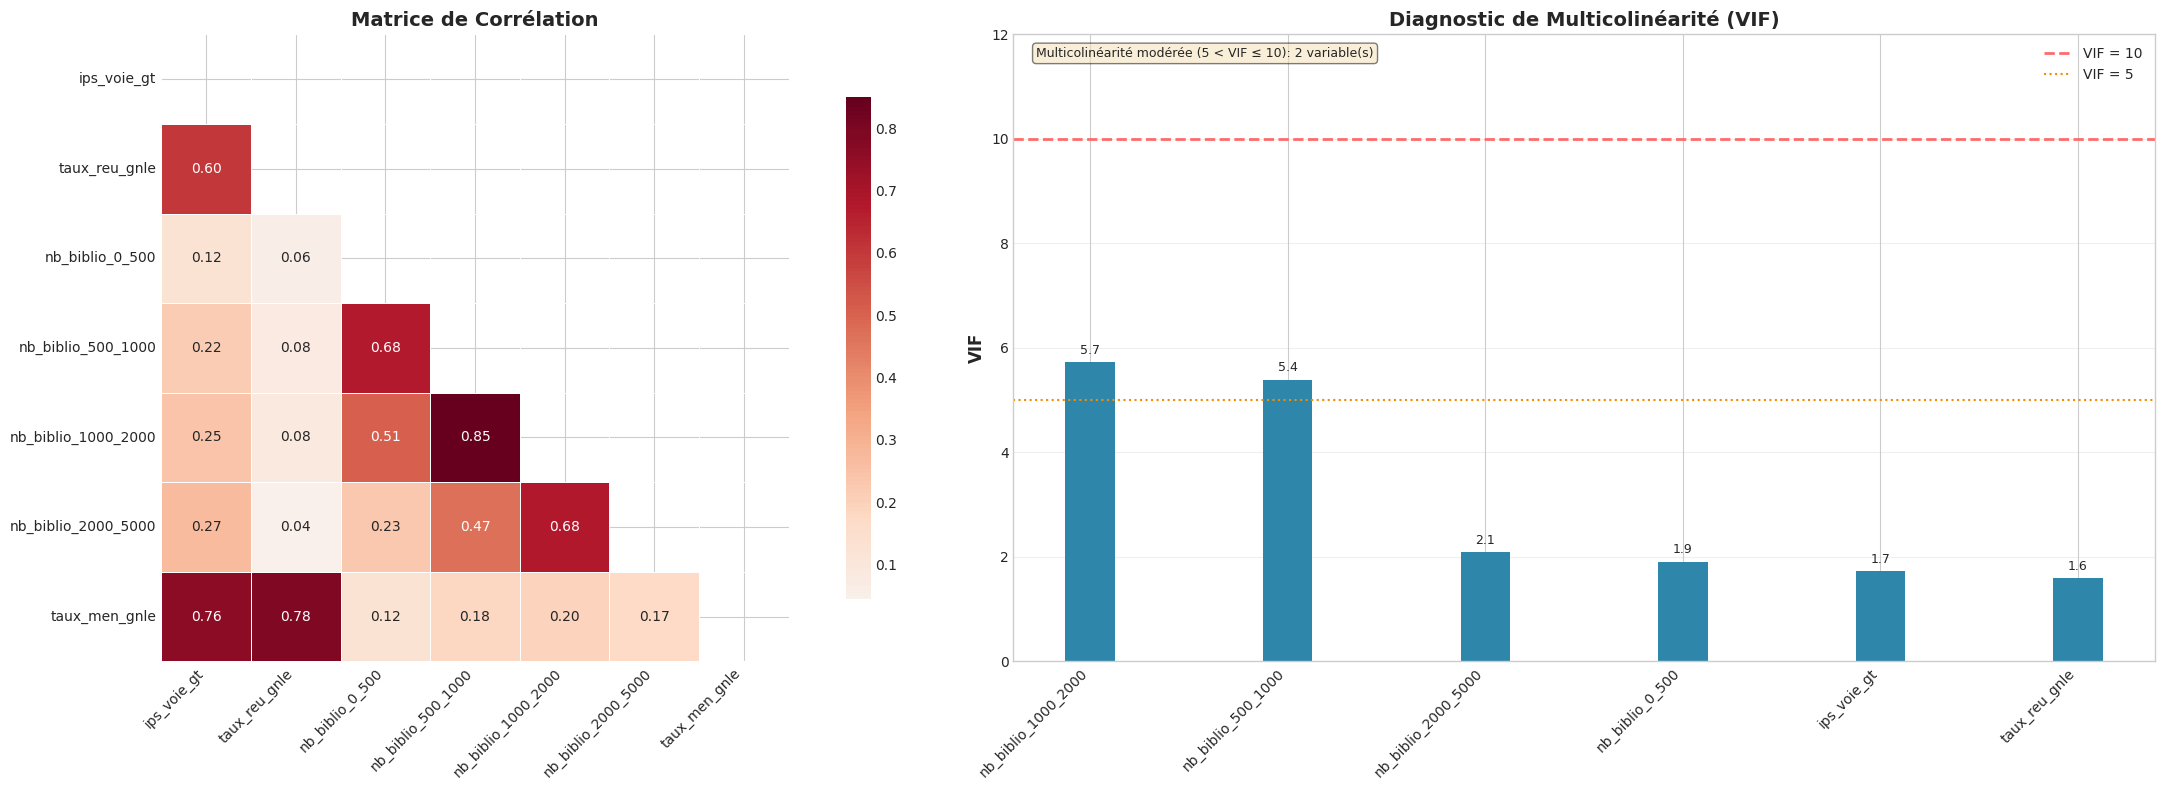

In [26]:
paires = model.paires_plot(data=data , features=features_5, target=target)
headmap_vif =  model.headmap_vif(data = data , features = features_5 , target = target)
plt.show()

* ### **Analyse et Interprétation des graphiques**

* ### **Résultats de la Régression**

In [27]:

model.fit_stepwise(data=data , features=features_5 , target=target , include_robust=True , standardisation=True , verbose=True)



================ÉTAPE 1 - FORWARD SELECTION================= 

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1126.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          7.39e-196
Time:                        16:43:25   Log-Likelihood:                -7041.9
No. Observations:                1981   AIC:                         1.409e+04
Df Residuals:                    1979   BIC:                         1.410e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

In [28]:
model.fit_stepwise(data=data , features=features_5 , target=target , include_robust=True , standardisation=True , verbose=False , best=True)

MEILLEUR MODÈLE AVEC FORWARD SELECTION
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1027.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:43:25   Log-Likelihood:                -6608.2
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.325e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

* ### **Analyse et Interprétation des résultats de la régression**

## **Conclusion**

## **Perspectives**